In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import json
import numpy 
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  
import pyarrow
import sys

from datetime import date
from dotenv import load_dotenv
from sqlalchemy import create_engine
from os import path
from typing import List,Dict, Tuple
from collections import defaultdict
pd.set_option("display.max_columns", None)

load_dotenv(verbose=True)
BIGQUERY_CREDENTIALS_PATH = os.environ.get('BIGQUERY_CREDENTIALS_PATH')
engine = create_engine('bigquery://bespoke-financial/ProdMetrcData', credentials_path=os.path.expanduser(BIGQUERY_CREDENTIALS_PATH))

sys.path.append(path.realpath(path.join(os.getcwd(), "../core")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../src")))
sys.path.append(path.realpath(path.join(os.getcwd(), "../../scripts")))

import create_queries
import prepare_data

from bespoke.inventory.analysis.shared import download_util, inventory_types
from bespoke.inventory.analysis import active_inventory_util as util
from bespoke.inventory.analysis import inventory_valuations_util as valuations_util

%load_ext autoreload
%autoreload 2

In [3]:
from underwriting import client_surveillance_jupyter

In [4]:
COMPANY_IDENTIFIER = ['MC']
TRANSFER_PACKAGES_START_DATE = '2020-01-01'
SALES_TRANSACTIONS_START_DATE = '2020-01-01'

In [5]:
#fetch download report and lisences
company_licenses_query = create_queries.create_company_licenses_query(COMPANY_IDENTIFIER)
company_download_summaries_query = create_queries.create_company_download_summaries_query(COMPANY_IDENTIFIER, TRANSFER_PACKAGES_START_DATE)

company_licenses_dataframe = pd.read_sql_query(company_licenses_query, engine)
company_download_summaries_dataframe = pd.read_sql_query(company_download_summaries_query, engine)

In [6]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,OR,020-100584842A8,Cultivator,"Greenphoria Farms, LLC",True,,OR-00651,Recreational Producer,fa9cf9c1-610f-4616-8d0a-a6dee90df879,None
1,OR,050-10111574ADA,Retailer,R A & R Inc.,True,,OR-00977,Recreational Retailer,fa9cf9c1-610f-4616-8d0a-a6dee90df879,0207a854-f0b6-4e59-a103-2d384846de7b


## Check download status summaries

In [7]:
license_numbers = company_download_summaries_dataframe['license_number'].unique()
download_summary_records = company_download_summaries_dataframe.to_dict('records')

In [8]:
license_numbers

array(['020-100584842A8', '050-10111574ADA'], dtype=object)

In [9]:
bad_download_history = client_surveillance_jupyter.check_company_license_download(license_numbers,download_summary_records)

Verifying download summaries for license 020-100584842A8...
Earliest download summary: 2021-01-01
Latest download summary: 2022-09-09

Verifying download summaries for license 050-10111574ADA...
Earliest download summary: 2021-01-01
Latest download summary: 2022-09-09

[SUCCESS] All download summaries look good!


In [10]:
bad_download_history

defaultdict(list, {})

## Choose license numbers

In [11]:
license_numbers = list(company_licenses_dataframe[company_licenses_dataframe['license_category'].isin(['Retailer', 'Multiple'])]['license_number'].unique())
license_numbers

['050-10111574ADA']

In [12]:
if COMPANY_IDENTIFIER == ['GRG']:
    license_numbers = ['C10-0000169-LIC']
elif COMPANY_IDENTIFIER == ['CSC']:
    license_numbers = ['C10-0000670-LIC']
license_numbers

['050-10111574ADA']

# License check

In [13]:
company_licenses_dataframe

,us_state,license_number,license_category,legal_name,is_current,license_status,rollup_id,license_description,company_id,facility_row_id
0,OR,020-100584842A8,Cultivator,"Greenphoria Farms, LLC",True,,OR-00651,Recreational Producer,fa9cf9c1-610f-4616-8d0a-a6dee90df879,None
1,OR,050-10111574ADA,Retailer,R A & R Inc.,True,,OR-00977,Recreational Retailer,fa9cf9c1-610f-4616-8d0a-a6dee90df879,0207a854-f0b6-4e59-a103-2d384846de7b


In [14]:
company_state = list(company_licenses_dataframe['us_state'].unique())[0]
company_state

'OR'

In [15]:
retial_license_check_df = company_licenses_dataframe[company_licenses_dataframe['license_number'].isin(license_numbers)][['license_number','license_category','is_current','license_status','us_state']].reset_index(drop = True)
retial_license_check_df['license_check'] = ['YES' if retial_license_check_df['license_status'][i] == 'Active' or str(retial_license_check_df['is_current'][i]) == 'True' else 'NO' for i in range(len(retial_license_check_df))]
retial_license_check_df


,license_number,license_category,is_current,license_status,us_state,license_check
0,050-10111574ADA,Retailer,True,,OR,YES


## Pull data

In [16]:
company_incoming_transfer_packages_query = create_queries.create_company_incoming_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_outgoing_transfer_packages_query = create_queries.create_company_outgoing_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
    license_numbers=license_numbers,
)
company_unknown_transfer_packages_query = create_queries.create_company_unknown_transfer_packages_query(
    COMPANY_IDENTIFIER,
    TRANSFER_PACKAGES_START_DATE,
#     license_numbers=license_numbers,
)
company_sales_transactions_query = create_queries.create_company_sales_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_query = create_queries.create_company_sales_receipts_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_sales_receipts_with_transactions_query = create_queries.create_company_sales_receipts_with_transactions_query(
    COMPANY_IDENTIFIER,
    SALES_TRANSACTIONS_START_DATE,
    license_numbers=license_numbers,
)
company_inventory_packages_query = create_queries.create_company_inventory_packages_query(
    COMPANY_IDENTIFIER,
    include_quantity_zero=True,
    license_numbers=license_numbers,
)



company_incoming_transfer_packages_dataframe = pd.read_sql_query(company_incoming_transfer_packages_query, engine)
company_outgoing_transfer_packages_dataframe = pd.read_sql_query(company_outgoing_transfer_packages_query, engine)
company_unknown_transfer_packages_dataframe = pd.read_sql_query(company_unknown_transfer_packages_query, engine)
company_sales_transactions_dataframe = pd.read_sql_query(company_sales_transactions_query, engine)
company_sales_receipts_dataframe = pd.read_sql_query(company_sales_receipts_query, engine)
company_sales_receipts_with_transactions_dataframe = pd.read_sql_query(company_sales_receipts_with_transactions_query, engine)
company_inventory_packages_dataframe = pd.read_sql_query(company_inventory_packages_query, engine)

In [17]:
#make sure we did pulled all location's data
company_incoming_transfer_packages_dataframe['license_number'].unique()

array(['050-10111574ADA'], dtype=object)

In [18]:
company_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['050-10111574ADA'], dtype=object)

In [19]:
company_inventory_packages_dataframe['license_number'].unique()

array(['050-10111574ADA'], dtype=object)

# pull repayment data (if any)

In [20]:
# fetch repayment history query
company_repayment_query = create_queries.create_company_repayment_history_query(COMPANY_IDENTIFIER)
company_repayment_data = pd.read_sql_query(company_repayment_query, engine)

In [21]:
company_repayment_data

,company_id,identifier,loan_id,loan_amount,outstanding_principal_balance,adjusted_maturity_date,last_settlement_date,total_paid,days_late_temp,days_late


## Unknown transfer packages

In [22]:
unknown_package_count = client_surveillance_jupyter.check_unknown_transfer_packages(company_unknown_transfer_packages_dataframe)
unknown_package_count

[SUCCESS] No unknown transfer packages!


0

## Receiver wholesale price coverage

In [23]:
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['receiver_wholesale_price'].notnull()].shape

(3005, 31)

In [24]:
company_incoming_transfer_packages_dataframe.shape

(4008, 31)

In [25]:
rwp_coverage = client_surveillance_jupyter.check_receiver_wholesale_price_coverage(company_incoming_transfer_packages_dataframe)


75.0% of incoming transfer packages have receiver wholesale price


## dedupe sales transactions

In [26]:
deduped_sales_receipts_with_transactions_dataframe = prepare_data.dedupe_sales_transactions(company_sales_receipts_with_transactions_dataframe)

In [27]:
deduped_sales_receipts_with_transactions_dataframe['sales_month'] = deduped_sales_receipts_with_transactions_dataframe['sales_datetime'].dt.strftime('%Y-%m')

In [28]:
#check we have all locations
deduped_sales_receipts_with_transactions_dataframe['license_number'].unique()

array(['050-10111574ADA'], dtype=object)

## Trxns missing incoming transfer packages

In [29]:
incoming_transfer_package_coverage,incoming_transfer_package_coverage_missing = client_surveillance_jupyter.check_incoming_transfer_package_coverage(company_incoming_transfer_packages_dataframe,deduped_sales_receipts_with_transactions_dataframe)

# transactions missing incoming transfer package: 41089 (50.89114306592849%)
# transactions total: 80739


In [30]:
month_to_missing_count = incoming_transfer_package_coverage_missing[['sales_month','receipt_number']].groupby(['sales_month']).apply(lambda x: len(x['receipt_number'].unique()))
month_to_missing_count


sales_month
2020-12     120
2021-01    2633
2021-02    1722
2021-03    2155
2021-04    2000
2021-05    1602
2021-06    1810
2021-07    1594
2021-08    1487
2021-09    1727
2021-10    1440
2021-11    1372
2021-12    1299
2022-01    1433
2022-02    1164
2022-03    1213
2022-04    1004
2022-05    1207
2022-06    1167
2022-07    1289
2022-08    1531
2022-09     369
dtype: int64

## Receipts missing metrc_sales_transactions

In [31]:
sales_receipt_with_transactions_records = deduped_sales_receipts_with_transactions_dataframe.to_dict('records')

receipt_number_to_transactions = {}
for sales_receipt_with_transaction_record in sales_receipt_with_transactions_records:
    receipt_number = sales_receipt_with_transaction_record['receipt_number']
    if receipt_number in receipt_number_to_transactions:
        receipt_number_to_transactions[receipt_number] += [sales_receipt_with_transaction_record]
    else:
        receipt_number_to_transactions[receipt_number] = [sales_receipt_with_transaction_record]

In [32]:
import math

def float_eq(receipt_total_price: float, transactions_total_price: float, num_transactions: int) -> bool:
    # For every additional transaction, increase threshold by 0.01 (a penny).
    threshold = num_transactions * 0.01
    return math.isclose(receipt_total_price, transactions_total_price, abs_tol=threshold)

mismatch_count = 0 # Count of receipts where receipt total price does not match transactions total price.
missing_count = 0 # Count of receipts with no transactions.
total_count = 0 # Count of receipts (including those missing transactions).

mismatch_over_count = 0
mismatch_under_count = 0

month_to_mismatch_count = {}
month_to_missing_count = {}

month_to_mismatch_over_count = {}
month_to_mismatch_under_count = {}

example_mismatch_over_receipts = []
example_mismatch_under_receipts = []

for receipt_number, receipt_transactions in list(receipt_number_to_transactions.items()):
    receipt_total_price = receipt_transactions[0]['rt_total_price']
    receipt_sales_month = receipt_transactions[0]['sales_month']
    receipt_total_packages = receipt_transactions[0]['total_packages']

    total_count += 1

    if len(receipt_transactions) == 1 and receipt_transactions[0]['tx_package_id'] == None:
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    # Check whether 'total_packages' field of sales receipt matches number of transactions related to receipt.
    if receipt_total_packages != len(receipt_transactions):
        missing_count += 1
        if receipt_sales_month not in month_to_missing_count:
            month_to_missing_count[receipt_sales_month] = 0
        month_to_missing_count[receipt_sales_month] += 1
        continue

    transactions_total_price = sum(receipt_transaction['tx_total_price'] for receipt_transaction in receipt_transactions)
    if not float_eq(receipt_total_price, transactions_total_price, len(receipt_transactions)):
        mismatch_count += 1
        if receipt_total_price < transactions_total_price:
            mismatch_over_count += 1
            example_mismatch_over_receipts += [(receipt_number, receipt_transactions)]
        else:
            mismatch_under_count += 1
            example_mismatch_under_receipts += [(receipt_number, receipt_transactions)]

        if receipt_sales_month not in month_to_mismatch_count:
            month_to_mismatch_count[receipt_sales_month] = 0
        month_to_mismatch_count[receipt_sales_month] += 1
        continue

print(f'# receipts with mismatching transactions: {mismatch_count} ({mismatch_count / total_count * 100}%)')
print(f'# receipts missing transactions: {missing_count} ({missing_count / total_count * 100}%)')
print(f'# receipts total: {total_count}')

if mismatch_count:
    print(f'# mismatch receipt vs transactions (transactions over): {mismatch_over_count} ({mismatch_over_count / mismatch_count * 100}%)')
    print(f'# mismatch receipt vs transactions (transactions under): {mismatch_under_count} ({mismatch_under_count / mismatch_count * 100}%)')

# receipts with mismatching transactions: 0 (0.0%)
# receipts missing transactions: 0 (0.0%)
# receipts total: 48439


In [33]:
company_sales_receipts_dataframe['sales_month'] = company_sales_receipts_dataframe['sales_datetime'].dt.strftime('%Y-%m')

<AxesSubplot:xlabel='sales_month'>

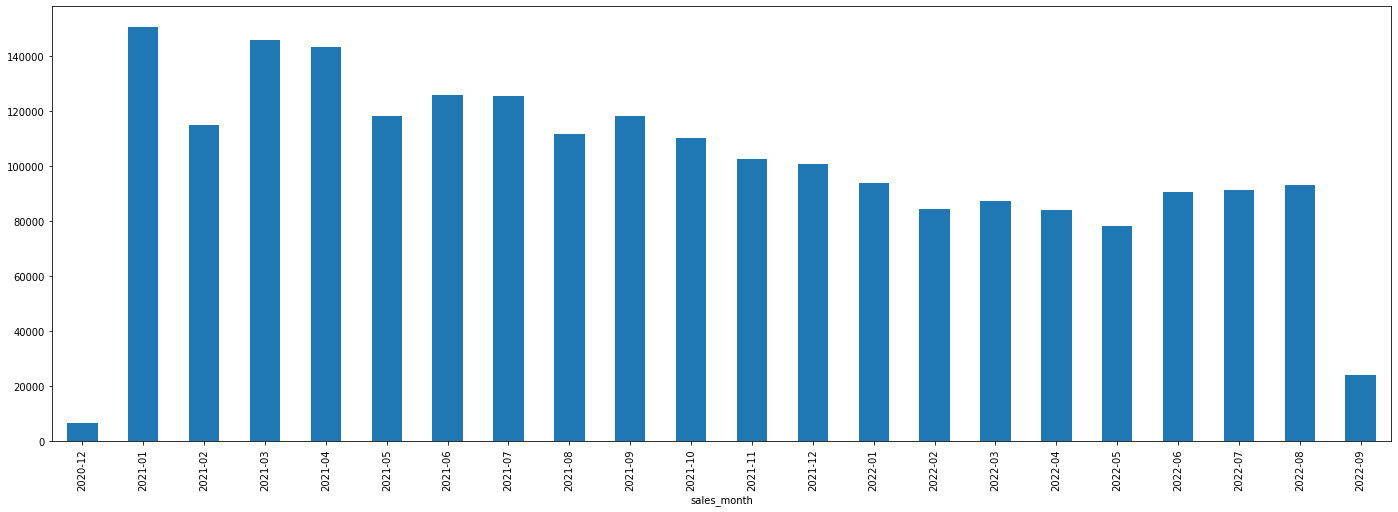

In [34]:
deduped_sales_receipts_with_transactions_dataframe.groupby(['sales_month'])['tx_total_price'].sum().plot.bar(figsize=(24, 8), stacked=True)

# Vendor churn

In [35]:
VC_START_DATE = '2020-01-01'
VC_END_DATE = '2022-08-01'
VC_MONTH_LIST = ['2022-05-01','2022-06-01','2022-07-01','2022-08-01']
VC_MONTH_END = VC_MONTH_LIST[-1]

In [36]:
churn,vc_matrix = client_surveillance_jupyter.calculate_vendor_churn(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST)


In [37]:
churn_short,vc_matrix_short = client_surveillance_jupyter.calculate_vendor_churn_short(company_incoming_transfer_packages_dataframe,license_numbers,VC_START_DATE,VC_END_DATE,VC_MONTH_LIST,VC_MONTH_END)


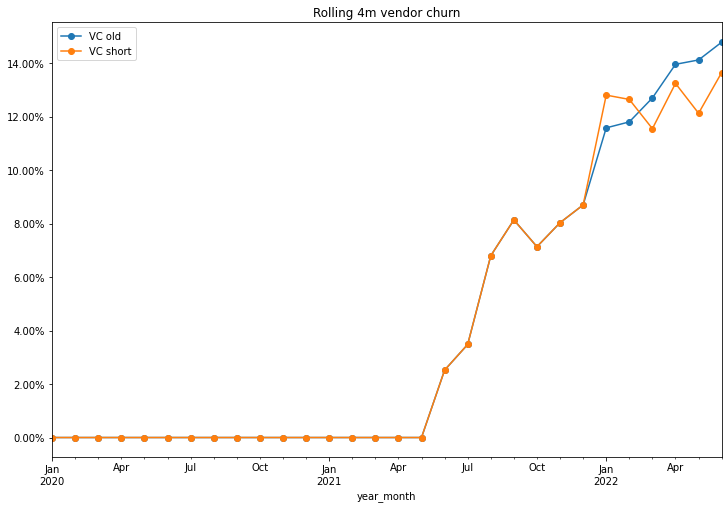

In [38]:
ax = churn['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC old')
ax = churn_short['%_inactive'].plot(marker = 'o',figsize = (12,8),label = 'VC short')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.2%}'.format(x) for x in vals])
ax = plt.title('Rolling 4m vendor churn')
ax = plt.legend()

# Receiver wholesale price outlier check

In [39]:
per_unit_incoming_package_sort,per_unit_incoming_product_sort = client_surveillance_jupyter.check_per_unit_incoming(company_incoming_transfer_packages_dataframe)


printing per unit incoming by package ID summary ...
max per unit incoming: 2031.488065007618 from package ID: 12578116
min per unit incoming: 2.2026431718061676e-05 from package ID: 17064141



In [40]:
# top 5
print('Top 5 per unit incoming packages')
per_unit_incoming_package_sort.head(20)

Top 5 per unit incoming packages


,package_id,per_unit_incoming
0,12578116,2031.488065
1,12152444,2000.000000
2,12099684,2000.000000
3,14597236,2000.000000
4,15015803,2000.000000
5,13776435,2000.000000
6,15513464,2000.000000
7,11530782,2000.000000
8,16197475,2000.000000
9,13269961,2000.000000


In [41]:
print('Bottom 5 per unit incoming packages')
per_unit_incoming_package_sort.dropna().tail(5)


Bottom 5 per unit incoming packages


,package_id,per_unit_incoming
3141,11711822,0.001667
3142,15896840,0.000333
3143,17064131,0.000022
3144,17064129,0.000022
3145,17064141,0.000022


In [42]:
# look at large cost items if any
company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] >= 10000]

,delivery_type,license_number,manifest_number,created_date,received_datetime,shipment_transaction_type,shipper_facility_license_number,shipper_facility_name,recipient_facility_license_number,recipient_facility_name,shipment_type_name,shipment_transaction_type_1,package_id,package_label,type,source_package_labels,source_harvest_names,shipment_package_state,is_testing_sample,is_trade_sample,product_category_name,product_name,package_lab_results_status,shipper_wholesale_price,shipped_quantity,shipped_unit_of_measure,receiver_wholesale_price,received_quantity,received_unit_of_measure,item_unit_weight,item_unit_weight_unit_of_measure_name,per_unit_incoming


# COGS analysis

In [43]:
df_in = company_incoming_transfer_packages_dataframe[company_incoming_transfer_packages_dataframe['per_unit_incoming'] < 10000]
df_inventory = company_inventory_packages_dataframe
df_sales = deduped_sales_receipts_with_transactions_dataframe

In [44]:
df_summary_simp,df_cogs_average_product = client_surveillance_jupyter.cogs_analysis(df_in,df_sales,'monthly',company_state)


In [ ]:
#df_summary_simp_uom,df_cogs_average_product_uom = client_surveillance_jupyter.cogs_analysis_uom(df_in,df_sales,'monthly',company_state)


In [ ]:
#plt.scatter(df_summary_simp['margin_%'] ,df_summary_simp_uom['margin_%'] )

In [45]:
df_summary_simp

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,count_incoming,coverage,total_count,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,150410.72,3131582.61,-2981171.89,-19.82,942.0,571.0,371,0.22,4278,172972.33,3953623.04,-3780650.71,-21.86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.82,NaN,NaN,NaN,NaN
2021-02,2021-02,114650.23,2397885.47,-2283235.24,-19.91,1312.0,208.0,1104,0.38,3419,131847.76,3027330.40,-2895482.64,-21.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-19.91,NaN,NaN,NaN,-0.24
2021-03,2021-03,145577.82,202504.84,-56927.02,-0.39,1516.0,27.0,1489,0.34,4429,167414.49,255662.36,-88247.86,-0.53,-13.38,NaN,NaN,5731972.91,-14.78,NaN,NaN,-0.39,-13.38,NaN,NaN,0.27
2021-04,2021-04,143204.99,19325.76,123879.23,0.87,1645.0,41.0,1604,0.38,4353,164685.74,24398.77,140286.97,0.85,-6.48,NaN,NaN,2619716.06,-7.21,NaN,NaN,0.87,-6.48,NaN,NaN,-0.02
2021-05,2021-05,118165.61,21953.87,96211.74,0.81,1627.0,9.0,1618,0.44,3677,135890.45,27716.76,108173.69,0.80,0.43,NaN,NaN,243784.46,0.37,NaN,NaN,0.81,0.43,NaN,NaN,-0.17
2021-06,2021-06,125850.52,19064.93,106785.59,0.85,1600.0,11.0,1589,0.40,4038,144728.10,24069.47,120658.63,0.83,0.84,-6.27,NaN,60344.55,0.83,-6.98,NaN,0.85,0.84,-6.27,NaN,0.07
2021-07,2021-07,125427.86,26531.93,98895.93,0.79,2086.0,72.0,2014,0.49,4250,144242.04,33496.56,110745.48,0.77,0.82,-2.83,NaN,67550.73,0.80,-3.21,NaN,0.79,0.82,-2.83,NaN,-0.00
2021-08,2021-08,111411.31,22358.56,89052.75,0.80,1841.0,30.0,1811,0.46,3984,128123.01,28227.69,99895.32,0.78,0.81,0.62,NaN,67955.42,0.79,0.58,NaN,0.80,0.81,0.62,NaN,-0.11
2021-09,2021-09,118200.00,20071.91,98128.09,0.83,1936.0,0.0,1936,0.46,4195,135930.00,25340.79,110589.21,0.81,0.81,0.82,-3.91,68962.41,0.79,0.81,-4.39,0.83,0.81,0.82,-3.91,0.06


In [47]:
def cogs_analysis_fill_by_product_category(df_in:pd.DataFrame,df_inventory:pd.DataFrame,df_sales:pd.DataFrame,freq: str,state) -> pd.DataFrame:
    df_sales['per_unit'] = df_sales['tx_total_price'] / df_sales['tx_quantity_sold']
    # set frequency
    if freq == 'monthly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%m")

    elif freq == 'weekly':
        df_sales['date'] = df_sales['sales_datetime'].dt.strftime("%Y-%W")

    # total # trxns    
    s_total_count = df_sales.groupby('date')['tx_total_price'].count()
    df_total_count = pd.Series(s_total_count).to_frame()
    df_total_count = df_total_count.reset_index()
    df_total_count.rename(columns={'tx_total_price':'total_count'}, inplace=True)
    # revenue
    s_revenue = df_sales.groupby('date')['tx_total_price'].sum()
    df_revenue = pd.Series(s_revenue).to_frame()
    df_revenue = df_revenue.reset_index()
    df_revenue.rename(columns={'tx_total_price': 'revenue'}, inplace=True)

    df_in['per_unit_incoming'] = df_in['shipper_wholesale_price'] / df_in['shipped_quantity']
    
    # per unit price by package id
    df_in_price = df_in[df_in['shipper_wholesale_price'].notnull()]
    average_incoming_package_id = df_in_price.groupby('package_id')['per_unit_incoming'].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # per unit price by product name
    average_incoming_product = df_in_price.groupby('product_name')['per_unit_incoming'].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(columns={'per_unit_incoming':'per_unit_product'}, inplace=True)
    # per unit price by product category name
    average_incoming_product_category = df_in_price.groupby('product_category_name')['per_unit_incoming'].mean()
    df_avg_product_cat = pd.Series(average_incoming_product_category).to_frame()
    df_avg_product_cat = df_avg_product_cat.reset_index()
    df_avg_product_cat.rename(columns={'per_unit_incoming':'per_unit_product_cat'}, inplace=True)
    
    # merge with (cogs by package id)
    df_cogs_package_id = pd.merge(df_sales, df_avg_incoming_price, left_on='tx_package_id', right_on='package_id', how='left')
    df_cogs_package_id['total_incoming'] = df_cogs_package_id['per_unit_incoming'] * df_cogs_package_id['tx_quantity_sold']
    df_cogs_package_id.replace([numpy.inf], numpy.nan, inplace=True)
    df_cogs_package_id_notnull = df_cogs_package_id[df_cogs_package_id['total_incoming'].notnull()]
    # sum cogs by package id
    s_cogs = df_cogs_package_id_notnull.groupby('date')['total_incoming'].sum()
    df_cogs_id = pd.Series(s_cogs).to_frame()
    df_cogs_id = df_cogs_id.reset_index()
    # count # of trxns by package id
    s_cogs_count = df_cogs_package_id_notnull.groupby('date')['total_incoming'].count()
    df_cogs_count = pd.Series(s_cogs_count).to_frame()
    df_cogs_count = df_cogs_count.reset_index()
    df_cogs_count.rename(columns={'total_incoming':'count_incoming'}, inplace=True)
    
    # merge with (cogs by product name)
    df_cogs_average_product = pd.merge(df_cogs_package_id, df_avg_product, left_on='tx_product_name', right_on='product_name', how='left')
    df_cogs_average_product['total_product'] = df_cogs_average_product['tx_quantity_sold'] * df_cogs_average_product['per_unit_product']
    # merge with (cogs by product category name)
    df_cogs_average_product_cat = pd.merge(df_cogs_average_product, df_avg_product_cat, left_on='tx_product_category_name', right_on='product_category_name', how='left')
    df_cogs_average_product_cat['total_product_cat'] = df_cogs_average_product_cat['tx_quantity_sold'] * df_cogs_average_product_cat['per_unit_product_cat']
    df_cogs_null = df_cogs_average_product_cat[df_cogs_average_product_cat['per_unit_incoming'].isnull()]
    df_cogs_product = df_cogs_null[(df_cogs_null['per_unit_product'].notnull())]
    df_cogs_product_null = df_cogs_average_product_cat[(df_cogs_average_product_cat['per_unit_incoming'].isnull())&(df_cogs_average_product_cat['per_unit_product'].isnull())]
    df_cogs_product_cat = df_cogs_product_null[df_cogs_product_null['per_unit_product_cat'].notnull()]
    
    # sum cogs filldown by product name
    product_sum = df_cogs_product.groupby('date')['total_product'].sum()
    df_product_sum = pd.Series(product_sum).to_frame()
    df_product_sum = df_product_sum.reset_index()
    df_product_sum.rename(columns={'total_product':'product_sum'}, inplace=True)
    # count # of trxn filldown by product name
    product_count = df_cogs_product.groupby('date')['total_product'].count()
    df_product_count = pd.Series(product_count).to_frame()
    df_product_count = df_product_count.reset_index()
    df_product_count.rename(columns={'total_product':'product_count'}, inplace=True)
    df_cogs_product_df = pd.merge(df_product_sum, df_product_count)
    
    # sum cogs filldown by product category name
    product_cat_sum = df_cogs_product_cat.groupby('date')['total_product_cat'].sum()
    df_product_cat_sum = pd.Series(product_cat_sum).to_frame()
    df_product_cat_sum = df_product_cat_sum.reset_index()
    df_product_cat_sum.rename(columns={'total_product_cat':'product_cat_sum'}, inplace=True)
    # count # of trxn filldown by product category name
    product_cat_count = df_cogs_product_cat.groupby('date')['total_product_cat'].count()
    df_product_cat_count = pd.Series(product_cat_count).to_frame()
    df_product_cat_count = df_product_cat_count.reset_index()
    df_product_cat_count.rename(columns={'total_product_cat':'product_cat_count'}, inplace=True)
    df_cogs_product_cat_df = pd.merge(df_product_cat_sum, df_product_cat_count)
    
    # prepare summary
    df_summary = pd.merge(df_revenue, df_cogs_product_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_product_cat_df, how='left')
    df_summary = pd.merge(df_summary, df_cogs_id, how='left')
    df_summary['product_sum'] = df_summary['product_sum'].fillna(0)
    df_summary['product_count'] = df_summary['product_count'].fillna(0)
    df_summary['product_cat_sum'] = df_summary['product_cat_sum'].fillna(0)
    df_summary['product_cat_count'] = df_summary['product_cat_count'].fillna(0)
    # total cogs = by product id cogs + by product name cogs + by product category name cogs
    df_summary['cogs'] = df_summary['total_incoming'] + df_summary['product_sum'] + df_summary['product_cat_sum']
    df_summary = pd.merge(df_summary, df_cogs_count)
    df_summary = pd.merge(df_summary, df_total_count)
    # total count = by package id count + by product count + by product category count
    df_summary['total_count_incoming'] = df_summary['count_incoming'] + df_summary['product_count'] + df_summary['product_cat_count']
    df_summary['margin_$'] = df_summary['revenue'] - df_summary['cogs']
    df_summary['margin_%'] = df_summary['margin_$'] / df_summary['revenue']
    df_summary['coverage'] = df_summary['total_count_incoming'] / df_summary['total_count']
    df_summary_simp = df_summary[['date', 'revenue', 'cogs', 'margin_$', 'margin_%', 'total_count_incoming','product_count','product_cat_count','total_count','count_incoming', 'coverage']]
    #df_summary_simp.index = df_summary_simp.date
    
    
        # tax treatment
    df_summary_simp["revenue_after_tax"] = df_summary_simp["revenue"] * 1.15
    df_summary_simp["cogs_after_tax"] = df_summary_simp["cogs"] * 1.2625
    df_summary_simp["margin_$_after_tax"] = (
        df_summary_simp["revenue_after_tax"] - df_summary_simp["cogs_after_tax"]
    )
    df_summary_simp["margin_%_after_tax"] = (
        df_summary_simp["margin_$_after_tax"] / df_summary_simp["revenue_after_tax"]
    )
    # past quarter pre tax
    df_summary_simp["gm_past_quarter"] = (
        df_summary_simp[["margin_%"]].rolling(3).mean().values
    )
    df_summary_simp["gm_past_2quarters"] = (
        df_summary_simp[["margin_%"]].rolling(6).mean().values
    )
    df_summary_simp["gm_past_3quarters"] = (
        df_summary_simp[["margin_%"]].rolling(9).mean().values
    )
    df_summary_simp["sum_cogs_past_3months"] = (
        df_summary_simp[["cogs"]].rolling(3).sum().values
    )
    # past quarter after tax
    df_summary_simp["gm_past_quarter_after_tax"] = (
        df_summary_simp[["margin_%_after_tax"]].rolling(3).mean().values
    )
    df_summary_simp["gm_past_2quarters_after_tax"] = (
        df_summary_simp[["margin_%_after_tax"]].rolling(6).mean().values
    )
    df_summary_simp["gm_past_3quarters_after_tax"] = (
        df_summary_simp[["margin_%_after_tax"]].rolling(9).mean().values
    )
    # revenue change
    # df_summary_simp['revenue_change'] = df_summary_simp['revenue'].pct_change()

    if state == "CA":
        df_summary_simp["gm_final"] = df_summary_simp["margin_%_after_tax"]

        df_summary_simp["gm_past_quarter_final"] = df_summary_simp[
            "gm_past_quarter_after_tax"
        ]
        df_summary_simp["gm_past_2quarters_final"] = df_summary_simp[
            "gm_past_2quarters_after_tax"
        ]
        df_summary_simp["gm_past_3quarters_final"] = df_summary_simp[
            "gm_past_3quarters_after_tax"
        ]
    else:
        df_summary_simp["gm_final"] = df_summary_simp["margin_%"]
        df_summary_simp["gm_past_quarter_final"] = df_summary_simp["gm_past_quarter"]
        df_summary_simp["gm_past_2quarters_final"] = df_summary_simp[
            "gm_past_2quarters"
        ]
        df_summary_simp["gm_past_3quarters_final"] = df_summary_simp[
            "gm_past_3quarters"
        ]
    df_summary_simp["revenue_change"] = df_summary_simp["revenue"].pct_change().values
    df_summary_simp.index = df_summary_simp.date
    df_summary_simp = df_summary_simp.round(2)
    
    
    return df_summary_simp,df_cogs_average_product_cat




In [48]:
df_summary_simp_cat_monthly,df_cogs_average_product_cat_monthly = cogs_analysis_fill_by_product_category(df_in,df_inventory,df_sales,'monthly',company_state)




In [49]:
df_summary_simp_cat_monthly

,date,revenue,cogs,margin_$,margin_%,total_count_incoming,product_count,product_cat_count,total_count,count_incoming,coverage,revenue_after_tax,cogs_after_tax,margin_$_after_tax,margin_%_after_tax,gm_past_quarter,gm_past_2quarters,gm_past_3quarters,sum_cogs_past_3months,gm_past_quarter_after_tax,gm_past_2quarters_after_tax,gm_past_3quarters_after_tax,gm_final,gm_past_quarter_final,gm_past_2quarters_final,gm_past_3quarters_final,revenue_change
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01,2021-01,150410.72,10955377.02,-10804966.30,-71.84,4211.0,571.0,3269,4278,371,0.98,172972.33,13831163.49,-13658191.16,-78.96,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-71.84,NaN,NaN,NaN,NaN
2021-02,2021-02,114650.23,6621972.69,-6507322.46,-56.76,3415.0,208.0,2103,3419,1104,1.00,131847.76,8360240.52,-8228392.75,-62.41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56.76,NaN,NaN,NaN,-0.24
2021-03,2021-03,145577.82,9946479.04,-9800901.22,-67.32,4429.0,27.0,2913,4429,1489,1.00,167414.49,12557429.79,-12390015.30,-74.01,-65.31,NaN,NaN,27523828.75,-71.79,NaN,NaN,-67.32,-65.31,NaN,NaN,0.27
2021-04,2021-04,143204.99,9376406.50,-9233201.51,-64.48,4353.0,41.0,2708,4353,1604,1.00,164685.74,11837713.21,-11673027.47,-70.88,-62.85,NaN,NaN,25944858.23,-69.10,NaN,NaN,-64.48,-62.85,NaN,NaN,-0.02
2021-05,2021-05,118165.61,7051899.07,-6933733.46,-58.68,3677.0,9.0,2050,3677,1618,1.00,135890.45,8903022.57,-8767132.12,-64.52,-63.49,NaN,NaN,26374784.61,-69.80,NaN,NaN,-58.68,-63.49,NaN,NaN,-0.17
2021-06,2021-06,125850.52,8867852.22,-8742001.70,-69.46,4038.0,11.0,2438,4038,1589,1.00,144728.10,11195663.43,-11050935.34,-76.36,-64.21,-64.76,NaN,25296157.79,-70.58,-71.19,NaN,-69.46,-64.21,-64.76,NaN,0.07
2021-07,2021-07,125427.86,6897217.27,-6771789.41,-53.99,4250.0,72.0,2164,4250,2014,1.00,144242.04,8707736.80,-8563494.76,-59.37,-60.71,-61.78,NaN,22816968.56,-66.75,-67.92,NaN,-53.99,-60.71,-61.78,NaN,-0.00
2021-08,2021-08,111411.31,5799978.18,-5688566.87,-51.06,3984.0,30.0,2143,3984,1811,1.00,128123.01,7322472.46,-7194349.45,-56.15,-58.17,-60.83,NaN,21565047.68,-63.96,-66.88,NaN,-51.06,-58.17,-60.83,NaN,-0.11
2021-09,2021-09,118200.00,7560417.95,-7442217.95,-62.96,4195.0,0.0,2259,4195,1936,1.00,135930.00,9545027.66,-9409097.66,-69.22,-56.00,-60.10,-61.84,20257613.40,-61.58,-66.08,-67.99,-62.96,-56.00,-60.10,-61.84,0.06


# debug low coverage

In [46]:
#what are the product categories ?
miss = df_cogs_average_product[df_cogs_average_product['per_unit_product'].isna()]
miss[['tx_product_category_name','tx_total_price']].groupby('tx_product_category_name').sum().sort_values(by = 'tx_total_price')

,tx_total_price
tx_product_category_name,
Topicals (each),120.84
Hemp Cannabinoid Product (each),193.36
Concentrate (each),409.31
Tinctures (each),2496.80
Infused Pre-Roll,2979.19
Shake/Trim (by strain),3079.11
Extracts (each),7537.26
Edibles (each),7547.92
Non-Infused (Plain) Pre-Roll,77824.74


In [73]:
miss[['tx_product_category_name','total_packages']].groupby('tx_product_category_name').sum().sort_values(by = 'total_packages')

,total_packages
tx_product_category_name,
Hemp Cannabinoid Product (each),14
Topicals (each),24
Concentrate (each),51
Shake/Trim (by strain),174
Tinctures (each),375
Infused Pre-Roll,574
Extracts (each),817
Edibles (each),1174
Buds,3959


In [63]:
df_cogs_average_product_cat_monthly[df_cogs_average_product_cat_monthly['tx_product_category_name'] == 'Buds (by strain)']

,license_number,receipt_number,rt_type,sales_customer_type,sales_datetime,sales_month,total_packages,rt_total_price,tx_type,tx_package_id,tx_package_label,tx_product_name,tx_product_category_name,tx_unit_of_measure,tx_quantity_sold,tx_total_price,per_unit,date,package_id,per_unit_incoming,total_incoming,product_name,per_unit_product,total_product,product_category_name,per_unit_product_cat,total_product_cat
9,050-10111574ADA,0135349873,active,Consumer,2022-09-08 17:28:53+00:00,2022-09,2,87.50,active,17714704,1A401030001FEF1000014084,Buds - OrGroTech - Birthday Cake,Buds (by strain),Grams,14.0,43.75,3.125000,2022-09,17714704,2.201835,30.825688,Buds - OrGroTech - Birthday Cake,2.201835,30.825688,Buds (by strain),398.096405,5573.349673
13,050-10111574ADA,0135349870,active,Consumer,2022-09-08 16:57:27+00:00,2022-09,2,102.08,active,19338899,1A401030001B38E000002387,Buds - GMO Cookies B-Bud,Buds (by strain),Grams,28.0,43.75,1.562500,2022-09,NaN,NaN,NaN,NaN,NaN,NaN,Buds (by strain),398.096405,11146.699346
14,050-10111574ADA,0135349869,active,Consumer,2022-09-08 16:48:53+00:00,2022-09,1,40.83,active,19356821,1A401030001B38E000002389,Buds - GMO Cookies,Buds (by strain),Grams,7.0,40.83,5.832857,2022-09,NaN,NaN,NaN,NaN,NaN,NaN,Buds (by strain),398.096405,2786.674836
19,050-10111574ADA,0135349866,active,Consumer,2022-09-08 16:24:04+00:00,2022-09,2,70.00,active,19314967,1A401030001B38E000002385,Buds - GMO Cookies,Buds (by strain),Grams,14.0,35.00,2.500000,2022-09,NaN,NaN,NaN,NaN,NaN,NaN,Buds (by strain),398.096405,5573.349673
20,050-10111574ADA,0135349866,active,Consumer,2022-09-08 16:24:04+00:00,2022-09,2,70.00,active,19242158,1A401030001B38E000002371,Buds - Sour OG,Buds (by strain),Grams,14.0,35.00,2.500000,2022-09,NaN,NaN,NaN,NaN,NaN,NaN,Buds (by strain),398.096405,5573.349673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80731,050-10111574ADA,0088654076,active,Consumer,2020-12-31 09:38:34+00:00,2020-12,1,33.33,active,11206816,1A4010300018A25000004970,Peach Ringz,Buds (by strain),Grams,3.5,33.33,9.522857,2020-12,NaN,NaN,NaN,NaN,NaN,NaN,Buds (by strain),398.096405,1393.337418
80732,050-10111574ADA,0088653980,active,Consumer,2020-12-31 09:36:50+00:00,2020-12,3,43.33,active,9684013,1A401030001B38E000001633,Buds - Grape OG B2,Buds (by strain),Grams,14.0,33.33,2.380714,2020-12,NaN,NaN,NaN,NaN,NaN,NaN,Buds (by strain),398.096405,5573.349673
80736,050-10111574ADA,0088653978,active,Consumer,2020-12-31 09:05:27+00:00,2020-12,1,46.67,active,9684013,1A401030001B38E000001633,Buds - Grape OG B2,Buds (by strain),Grams,28.0,46.67,1.666786,2020-12,NaN,NaN,NaN,NaN,NaN,NaN,Buds (by strain),398.096405,11146.699346
80737,050-10111574ADA,0088653977,active,Consumer,2020-12-31 09:03:37+00:00,2020-12,2,92.50,active,11257879,1A401030001B38E000001827,Buds - Black Jack,Buds (by strain),Grams,7.0,59.17,8.452857,2020-12,NaN,NaN,NaN,NaN,NaN,NaN,Buds (by strain),398.096405,2786.674836


In [60]:
df_in[df_in['product_category_name'] == 'Buds (by strain)']['shipped_unit_of_measure'].unique()

array(['Grams', 'Pounds'], dtype=object)

In [61]:
df_sales[df_sales['tx_product_category_name'] == 'Buds (by strain)']['tx_unit_of_measure'].unique()

array(['Grams'], dtype=object)

In [69]:
df_sales[df_sales['tx_product_category_name'] == 'Buds (by strain)']['per_unit'].mean()

4.640431662076161

In [68]:
df_in[(df_in['product_category_name'] == 'Buds (by strain)')&(df_in['shipped_unit_of_measure'] == 'Grams')]['per_unit_incoming'].mean()

1.5922175767479387

# Revenue change vs state

In [ ]:
if COMPANY_IDENTIFIER == ['NECC']:
    a = client_surveillance_jupyter.calculate_quarterly_sum_gmv_ma_short(df_summary_simp)
    a

In [ ]:
if COMPANY_IDENTIFIER == ['NECC']:
    round(a.dropna()['total'].sum(),2)

In [ ]:
a = client_surveillance_jupyter.get_gmv_change(company_state,df_summary_simp)
round(a.dropna()['total'].sum(),2)

In [ ]:
a

# Inventory

In [ ]:
today = date.today()
today

In [ ]:
COMPANY_IDENTIFIER

In [ ]:
license_numbers

In [ ]:
df_inventory_license = client_surveillance_jupyter.calculate_inventory_valuation(df_in,df_inventory,license_numbers,today)

In [ ]:
df_inventory_license

In [ ]:
df_inventory_license_msrp = client_surveillance_jupyter.calculate_msrp_based_inventory_valuation(df_in,df_sales,df_inventory,license_numbers,today)

In [ ]:
df_inventory_license_msrp

In [ ]:
df_inventory_fresh,_ = client_surveillance_jupyter.calculate_inventory_valuation_fresh(df_in,df_inventory,license_numbers,today)

In [ ]:
df_inventory_fresh

In [ ]:
def calculate_inventory_valuation_by_group(
    incoming_transfer_df, inventory_df, license_list, today_date
):
    # legal name
    legal_name = incoming_transfer_df[
        incoming_transfer_df["license_number"].isin(license_list)
    ]["recipient_facility_name"].values[0]
    # process df_in and df_sales
    incoming_transfer_df["per_unit_incoming"] = (
        incoming_transfer_df["shipper_wholesale_price"]
        / incoming_transfer_df["shipped_quantity"]
    )
    incoming_transfer_df_price = incoming_transfer_df[
        incoming_transfer_df["shipper_wholesale_price"].notnull()
    ]
    # by package id
    average_incoming_package_id = incoming_transfer_df_price.groupby(["package_id"])[
        "per_unit_incoming"
    ].mean()
    df_avg_incoming_price = pd.Series(average_incoming_package_id).to_frame()
    df_avg_incoming_price = df_avg_incoming_price.reset_index()
    # by product
    average_incoming_product = incoming_transfer_df_price.groupby(["product_name"])[
        "per_unit_incoming"
    ].mean()
    df_avg_product = pd.Series(average_incoming_product).to_frame()
    df_avg_product = df_avg_product.reset_index()
    df_avg_product.rename(
        columns={"per_unit_incoming": "per_unit_product"}, inplace=True
    )
    inventory_df = get_valid_inventory_df(inventory_df)

    # inventory aging grouping
    inventory_df = inventory_df.reset_index(drop=True)
    inventory_df["age"] = [
        today_date - inventory_df["packaged_date"][i] for i in range(len(inventory_df))
    ]
    inventory_df["age_int"] = [
        inventory_df["age"][i] / numpy.timedelta64(1, "D")
        for i in range(len(inventory_df))
    ]
    inventory_df['group'] = inventory_df.apply(lambda row: group_inventory_df(180,270,row['age_int']),axis = 1)
    
    # calculate inventory
    df_inventory_incoming = pd.merge(
        inventory_df,
        df_avg_incoming_price,
        left_on=["package_id"],
        right_on=["package_id"],
        how="left",
    )

    df_inventory_incoming.replace([numpy.inf], numpy.nan, inplace=True)
    df_inventory_incoming["total_price"] = (df_inventory_incoming["quantity"] * df_inventory_incoming["per_unit_incoming"])
    df_inventory_incoming_summary = df_inventory_incoming[['group','total_price']].groupby('group').sum().reset_index()
    df_inventory_incoming_summary.columns = ['group','total_from_pkg']
    
    df_inv_null = df_inventory_incoming[
        df_inventory_incoming["per_unit_incoming"].isnull()
    ]
    df_inv_product = pd.merge(
        df_inv_null,
        df_avg_product,
        left_on=["product_name"],
        right_on=["product_name"],
        how="left",
    )
    df_inv_product.replace([numpy.inf], numpy.nan, inplace=True)
    df_inv_product_price = df_inv_product[df_inv_product["per_unit_product"].notnull()]
    df_inv_product_price["total_price"] = (df_inv_product_price["quantity"] * df_inv_product_price["per_unit_product"])
    df_inv_product_price_summary = df_inv_product_price[['group','total_price']].groupby('group').sum().reset_index()
    df_inv_product_price_summary.columns = ['group','total_from_prod']
    df_inv_group_merged = df_inventory_incoming_summary.merge(df_inv_product_price_summary,how = 'outer',on = 'group')
    df_inv_group_merged = df_inv_group_merged.fillna(0)
    df_inv_group_merged['total_value'] = df_inv_group_merged['total_from_pkg'] + df_inv_group_merged['total_from_prod']
    # inventory valuation by group pre-tax
    inventory_value_fresh = df_inv_group_merged[df_inv_group_merged['group'] == 'fresh']['total_value'].values[0]
    
    inventory_value_stale = df_inv_group_merged[df_inv_group_merged['group'] == 'stale']['total_value'].values[0]
    
    inventory_value_bad = df_inv_group_merged[df_inv_group_merged['group'] == 'bad']['total_value'].values[0]
    
    #inventory valuation by group post-tax
    inventory_value_fresh_after_tax = inventory_value_fresh * 1.2625
    inventory_value_stale_after_tax = inventory_value_stale * 1.2625
    inventory_value_bad_after_tax = inventory_value_bad * 1.2625
    
    # total valuation pre-tax
    inventory_value = df_inventory_incoming["total_price"].sum()
    inventory_product_value = df_inv_product_price["total_price"].sum()
    total_inv_value = inventory_product_value + inventory_value
    
    # total valuation post-tax
    total_inv_value_after_tax = (inventory_product_value + inventory_value) * 1.2625

    # count and coverage
    inv_count_product = df_inv_product_price["per_unit_product"].count()
    inv_count_incoming = df_inventory_incoming["per_unit_incoming"].count()
    inv_count_total = df_inventory_incoming["quantity"].count()
    inv_total_incoming = inv_count_product + inv_count_incoming
    inventory_coverage = inv_total_incoming / inv_count_total
    # prepare data
    data = [
        [today_date],
        [round(total_inv_value, 2)],
        [round(total_inv_value_after_tax, 2)],
        #grouping
        [round(inventory_value_fresh, 2)],
        [round(inventory_value_fresh_after_tax, 2)],
        [round(inventory_value_stale, 2)],
        [round(inventory_value_stale_after_tax, 2)],
        [round(inventory_value_bad, 2)],
        [round(inventory_value_bad_after_tax, 2)],
        [inv_total_incoming],
        [inv_count_total],
        [round(inventory_coverage, 2)],
        [license_list],
        [legal_name],
    ]
    df_inventory_license = pd.DataFrame(data).T
    df_inventory_license.columns = [
        "date",
        "value",
        "value_after_tax",
        "fresh value",
        "fresh value after tax",
        "stale value",
        "stale value after tax",
        "bad value",
        "bad value after tax", 
        "total_incoming",
        "total",
        "coverage",
        "license",
        "legal_name",
    ]
    return df_inventory_license, inventory_df
                                            

In [ ]:
def get_valid_inventory_df(inventory_data):
    #exclude trade samples
    inventory_data = inventory_data[~inventory_data['is_trade_sample']]
    #exclude quantity zero packages
    inventory_data = inventory_data[inventory_data['quantity'] > 0]
    return inventory_data

In [ ]:
def group_inventory_df(fresh_cutoff,stale_cutoff,item_age):
    if item_age <= fresh_cutoff:
        group = 'fresh'
    elif fresh_cutoff < item_age <= stale_cutoff:
        group = 'stale'
    else:
        group = 'bad'
    return group

In [ ]:
df_inventory_by_group,_ = calculate_inventory_valuation_by_group(df_in,df_inventory,license_numbers,today)



In [ ]:
df_inventory_by_group

# Quantity based inventory TO

In [ ]:
df_inventory.head()

In [ ]:
inventory_q = df_inventory[['package_id','unit_of_measure','quantity']].groupby(['package_id','unit_of_measure']).sum()



In [ ]:
inventory_q = inventory_q.reset_index()
inventory_q

In [ ]:
df_sales_3m = df_sales[df_sales['sales_month'] >= '2022-03']

In [ ]:
sales_q = df_sales_3m[['tx_package_id','tx_unit_of_measure','tx_quantity_sold']].groupby(['tx_package_id','tx_unit_of_measure']).sum()
sales_q = sales_q.reset_index()


In [ ]:
j = inventory_q.merge(sales_q,how = 'left',left_on = ['package_id','unit_of_measure'],right_on = ['tx_package_id','tx_unit_of_measure'])



In [ ]:
j['to'] = j['tx_quantity_sold'] / j['quantity'] * 4

In [ ]:
j[j['to'] >= 50]

In [ ]:
j['to'].describe()

# Repayment score

In [ ]:
company_repayment_data

In [ ]:
company_repayment_data_due = company_repayment_data[company_repayment_data['adjusted_maturity_date'] < today]

In [ ]:
company_repayment_data_due


In [ ]:
company_repayment_data_due['weight'] = company_repayment_data_due['loan_amount'] / sum(company_repayment_data_due['loan_amount'])

In [ ]:
len(company_repayment_data_due)

In [ ]:
if len(company_repayment_data_due) == 0:
    weighted_dpd = numpy.nan
else:
    weighted_dpd = sum(company_repayment_data_due['days_late'] * company_repayment_data_due['weight'])

    

In [ ]:
weighted_dpd

In [ ]:
repayment_score = client_surveillance_jupyter.get_short_repayment_score(weighted_dpd)
repayment_score

# Create Template: updated

In [ ]:
current_month = '2022-05'
full_score = 45

In [ ]:
license_numbers

In [ ]:
template_new_ = client_surveillance_jupyter.create_template_update(a,df_summary_simp,df_inventory_license,df_inventory_license_msrp,df_inventory_fresh,churn_short,retial_license_check_df,license_numbers,company_state,current_month)



In [ ]:
template_new_

# Output data 

In [ ]:
license_numbers

## others

In [ ]:
# for only 1 license
license_number = license_numbers[0]
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) + '_' +license_number +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE + '_' +license_number +'_rev_change_vs_state.csv')
#retial_license_check_df



In [ ]:
# multiple licenses
template_new_.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month + '/template/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_template.csv')
df_inventory_license.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today)  +'_inventory_val.csv')
df_inventory_fresh.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_fresh.csv')
df_inventory_license_msrp.to_csv('../analysis/surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/INV/' + COMPANY_IDENTIFIER[0] + '_'+ str(today) +'_inventory_msrp.csv')
df_summary_simp.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/COGS/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE +'_cogs.csv')
vc_matrix_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc_matrix.csv')
churn_short.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/VC/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_vc.csv')
a.to_csv('surveillance/'+COMPANY_IDENTIFIER[0]+'/'+current_month +'/rev_change_vs_state/' + COMPANY_IDENTIFIER[0] + '_'+ VC_END_DATE  +'_rev_change_vs_state.csv')
#retial_license_check_df



# Appendix

In [ ]:
# def calculate_quarterly_sum_gmv_ma_short(cogs_analysis_df):

#     gmv_df = cogs_analysis_df[(cogs_analysis_df['date'] >= '2021-09')&(cogs_analysis_df['date'] <= '2022-02')][['revenue_change']]
#     gmv_df['sum_gmv_change_ma'] = [-0.07,0.09,-0.11,0.02]
#     gmv_df['weight'] = [0.76,0.84,0.92,1]
#     gmv_df['variance'] = gmv_df['revenue_change'] - gmv_df['sum_gmv_change_ma']
#     gmv_df['points'] = [gmv_change_variance_point_mapping(n) for n in gmv_df['variance']]
#     gmv_df.replace([numpy.inf, -numpy.inf], numpy.nan, inplace=True)
#     gmv_df['total'] = gmv_df['points'] * gmv_df['weight']
#     return gmv_df
    